Process all Photographic plate FITS files \
Check validity of FITS Headers -- Are existing values sensible? \
        ***DO NOT MANIPULATE EXISTING FITS VALUES*** \
        ***IF CHANGED, ADD COMMENT TO HEADER*** \
Assign correct WCS data to FITS

    Ads
    - Find clean image of plate grids
        - check if all same scale
    - Plate solve to get correct info
        - Identify grid lines, handwriting
        - Align reference grid 
            - Subtract from plate
            - remove handwriting ?
            - Probably need to crop at least to outer grid 
        - Plate Solve
            - Compare existing info
            - Append WCS info

Contact Perth
    Instrument specs
        Focal length, filters
    Original Plate! 
        'Unexposed', clean image to use as reference
    

What objects in images?  All stars? galaxies?
                            Different masking processes

import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import sys
import glob
import astropy.coordinates as acoord
from scipy import ndimage
from scipy.interpolate import interp1d
import warnings

!pip install pyplate

#from PlatesFunc import xxxxxx


In [2]:
import os, sys, math
import sys
import math
import glob


#!pip install photutils
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord, FK4, FK5, Angle
from astropy.time import Time
import astropy.coordinates as acoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from scipy import ndimage
import shutil

from photutils.detection import DAOStarFinder

from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

import cv2

from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

from PlatesFunc import *

In [3]:

# Open the FITS file
try:
    hdu_list = fits.open('plate218rot4269.fits', ignore_missing_simple = True)
except FileNotFoundError:
    print("example.fits not found. Please provide a valid FITS file.")
    exit()

# Access the image data
fitsimage = hdu_list[0].data

# Define cropping region (e.g., center 100x100 pixels)
rows, cols = fitsimage.shape
center_row, center_col = rows // 2, cols // 2

half_size = 5000

min_row = center_row - half_size
max_row = center_row + half_size
min_col = center_col - half_size
max_col = center_col + half_size

# Ensure the crop region stays within image bounds
min_row = max(0, min_row)
max_row = min(rows, max_row)
min_col = max(0, min_col)
max_col = min(cols, max_col)

# Crop the image data
cropped_data = fitsimage[min_row:max_row, min_col:max_col]
inverted = (2**16 -1) - cropped_data
cropped_data = inverted
# Create a new HDU for the cropped data
cropped_hdu = fits.PrimaryHDU(cropped_data)

# Save the cropped image
cropped_hdu.writeto('cropped_example.fits', overwrite=True)

if fitsimage.dtype == object or '<U' in str(fitsimage.dtype):
    raise TypeError("Image data is of string type and cannot be converted to float.")
hdu_list.close()

croppedimage = fits.open('cropped_example.fits')

croppedimage = croppedimage[0].data   

#plt.imshow(croppedimage)

gray = fits.open('cropped_example.fits')
gray = gray[0].data
gray = gray 
print(gray.dtype)
gray = gray.astype(np.uint16) 
cv2.imwrite("gray.png", gray)
# Close the original FITS file
print(np.max(gray))


print("Image cropped and saved to cropped_example.fits")

uint16
59159
Image cropped and saved to cropped_example.fits


No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!
No lines found!


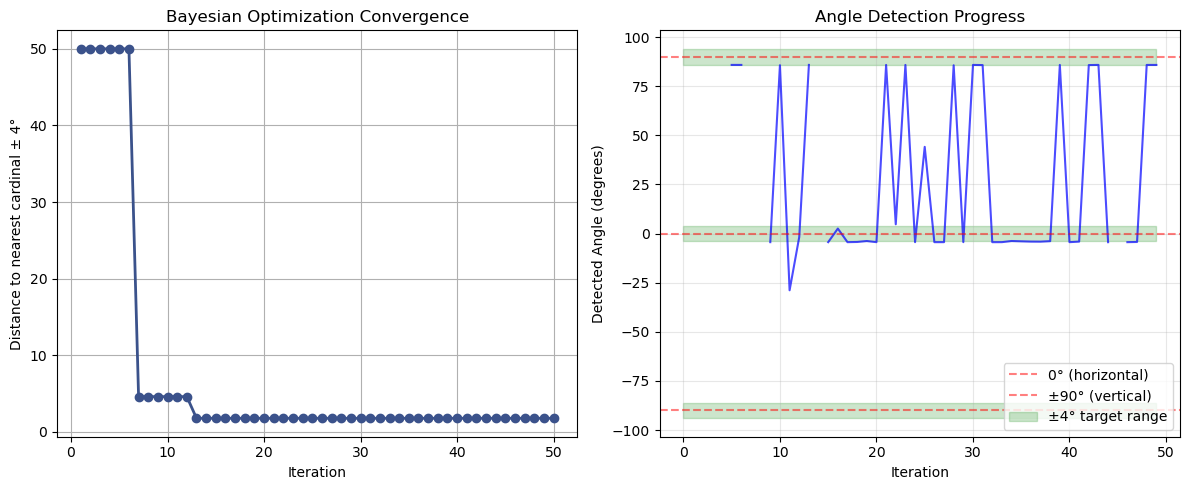

Detected angle: -1.78°
Correction angle: 1.78°
Best Parameters:
  cth1: 43
  cth2: 225
  hth: 10
  minLineLength: 400
  maxLineGap: 318
  detected_angle: -1.781254543211153
  distance_to_cardinal: 1.781254543211153
  within_target_range: True
  target_range: 4
  optimization_score: 1.781254543211153


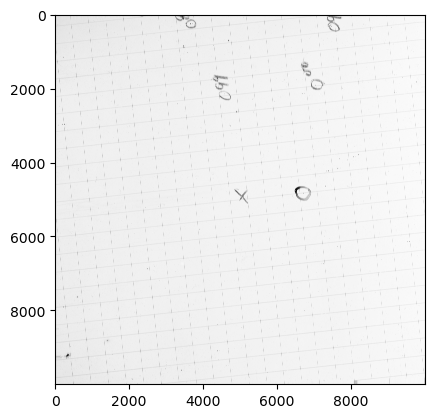

In [6]:

from skopt.utils import use_named_args
gray = cv2.imread("gray.png", cv2.IMREAD_UNCHANGED )

out_img_rot, best = optimize_params_bayes_range_script(gray, angleout =0, target_range=4, n_calls=50, plot=True)

print("Best Parameters:")
for k, v in best.items():
    print(f"  {k}: {v}")

plt.imshow(out_img_rot, cmap = 'Grays')

error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img data type = complex128 is not supported
>  - Expected Ptr<cv::UMat> for argument 'img'


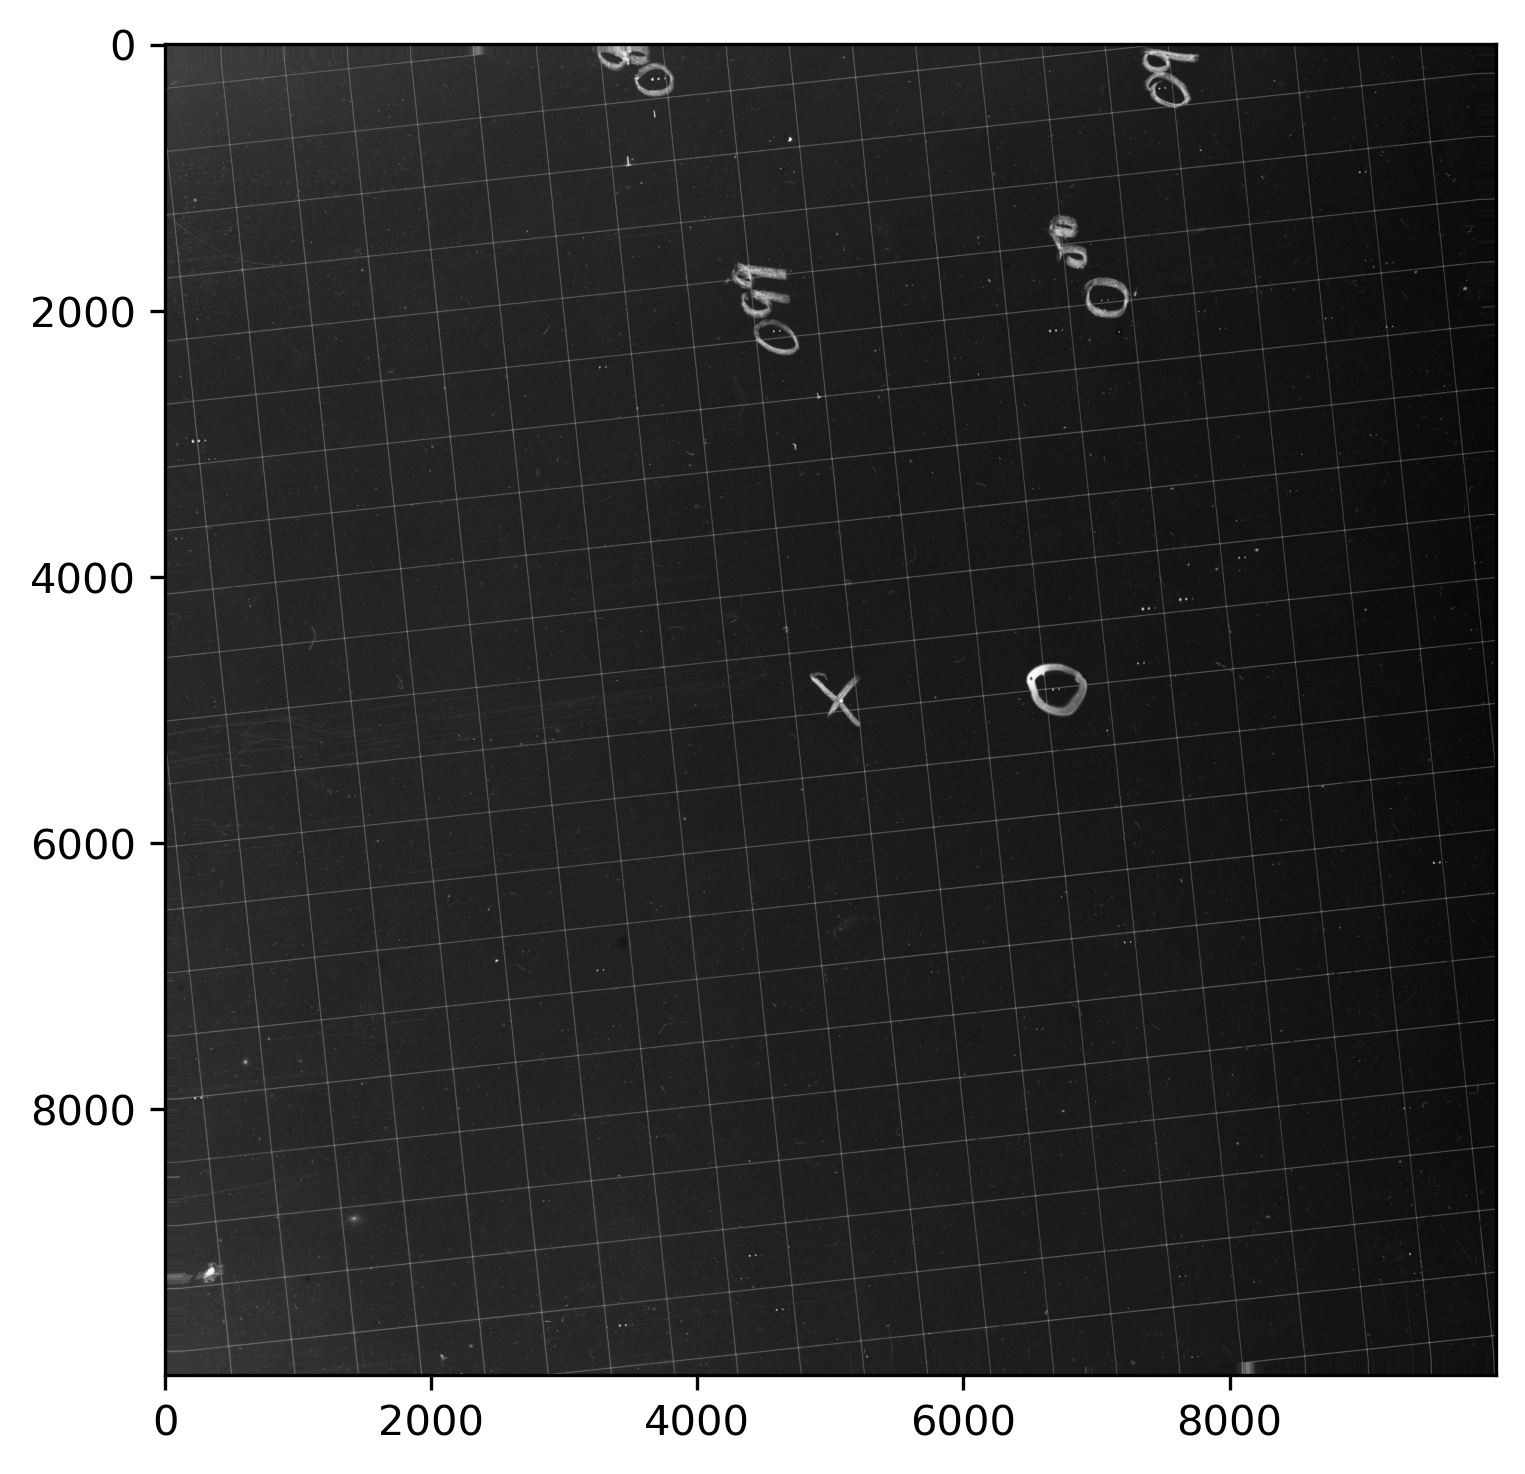

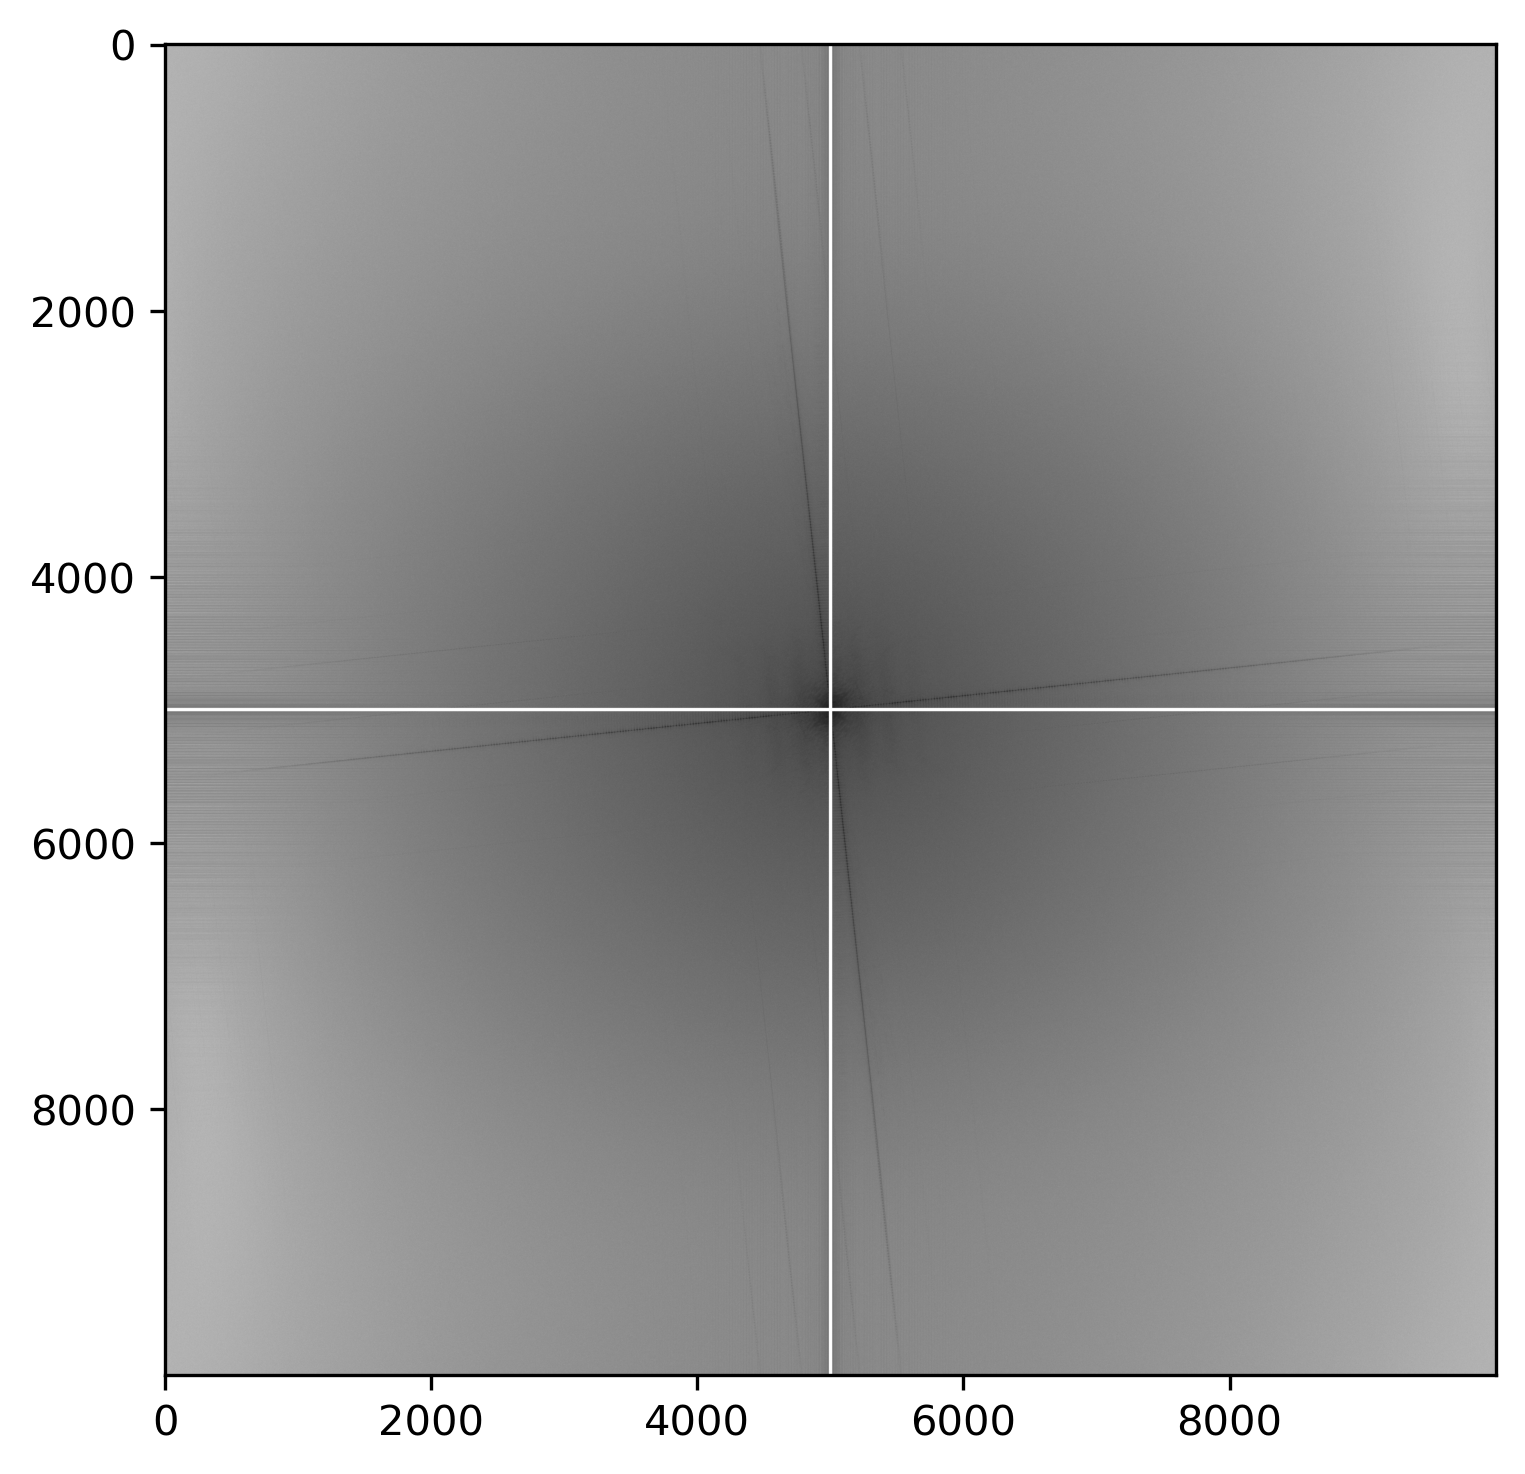

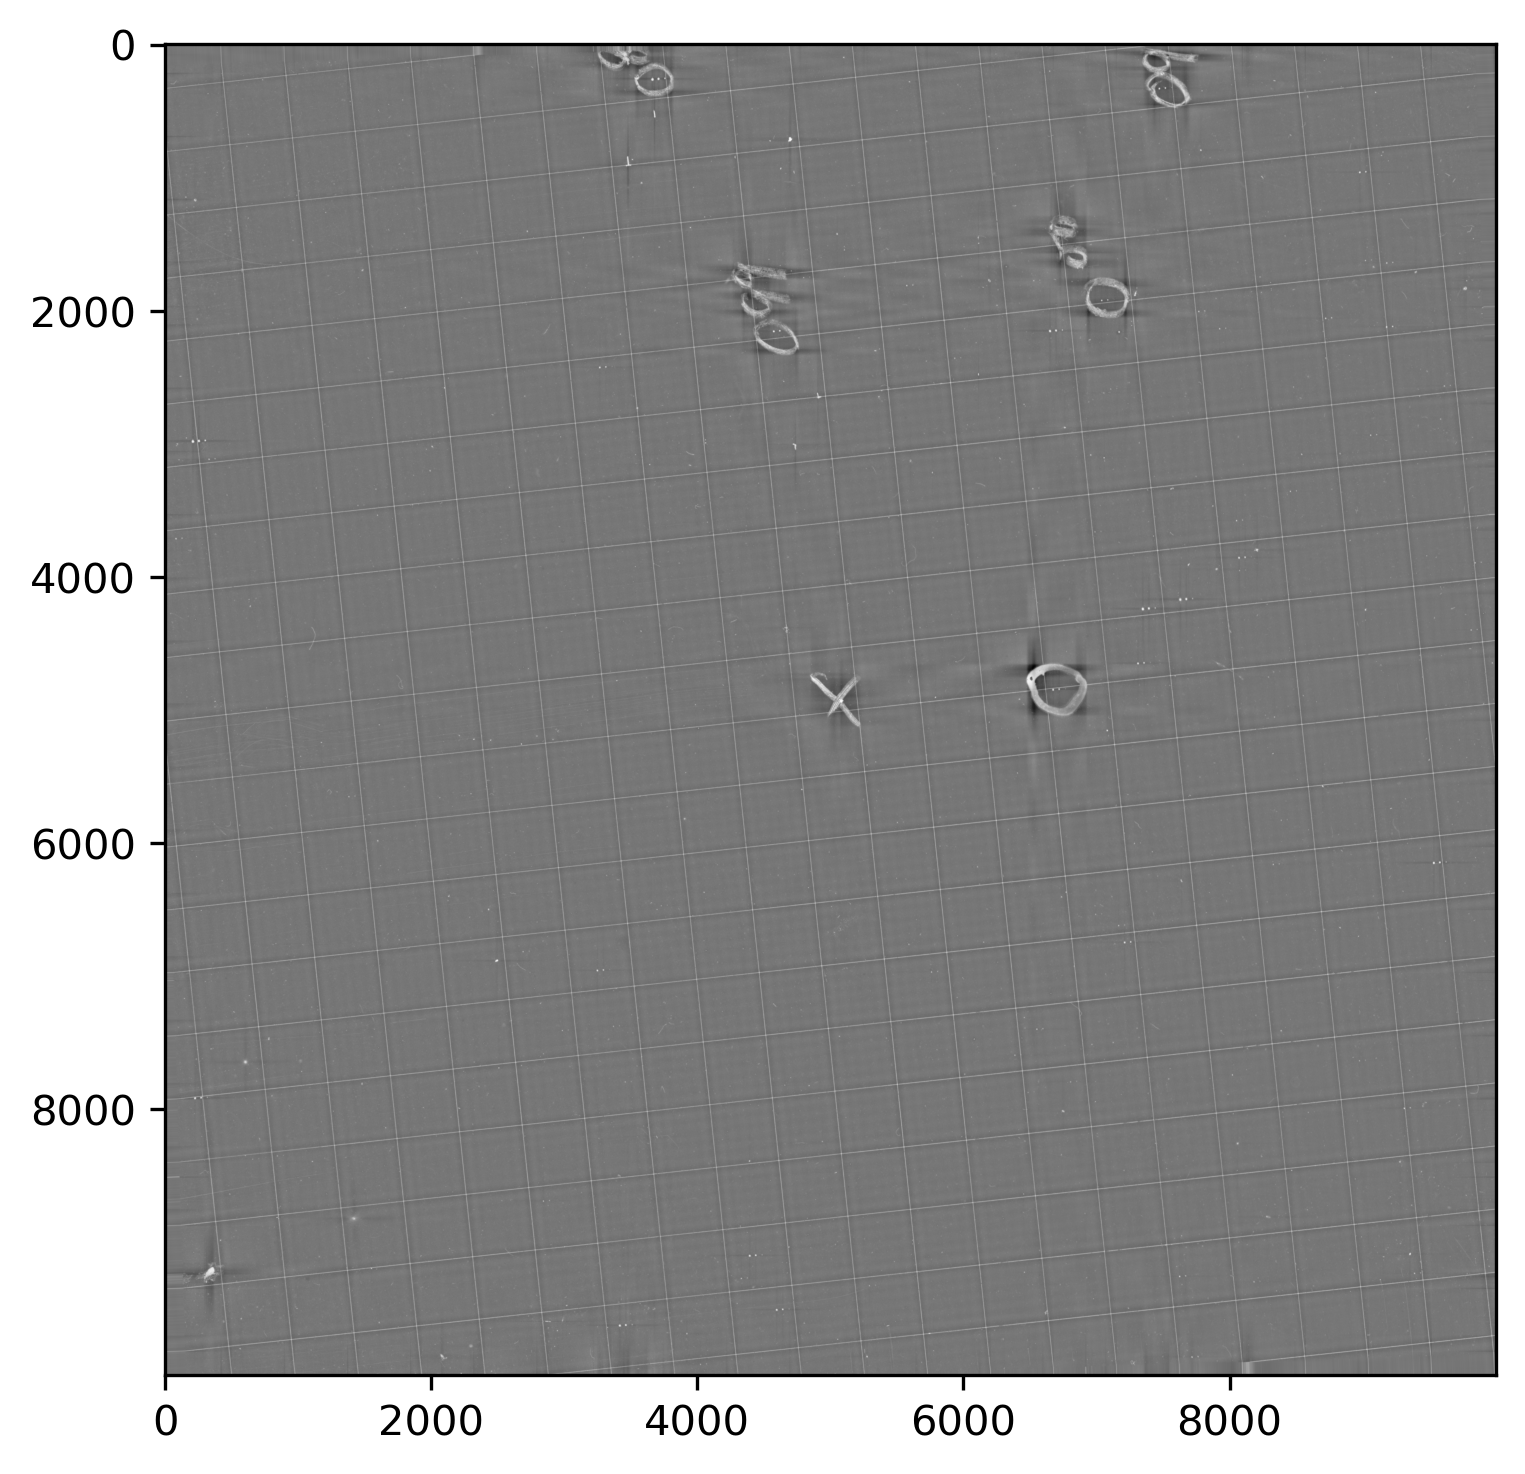

In [5]:
out_img_rot = (2**16 -1) - out_img_rot
rot_fft = np.fft.fft2(out_img_rot)
rot_fft_shifted = np.fft.fftshift(rot_fft)  # Shift DC to center

# Apply mask to shifted FFT
fft_masked = apply_cross_mask_to_fft(rot_fft_shifted, 25)
fft_disp = cv2.convertScaleAbs(np.log1p(np.abs(fft_masked)))

# Shift back before inverse FFT
fft_masked_unshifted = np.fft.ifftshift(fft_masked)
nogrid_image = np.fft.ifft2(fft_masked_unshifted)

fig, ax1 = plt.subplots(dpi = 300, layout = 'constrained')
ax1.imshow(out_img_rot, cmap = 'Grays')
fig, ax2 = plt.subplots(dpi = 300, layout = 'constrained')
ax2.imshow(fft_disp, cmap = 'Grays')
fig, ax3 = plt.subplots(dpi = 300, layout = 'constrained')
ax3.imshow(np.real(nogrid_image), cmap = 'Grays')

FFTOutput =  (np.real(nogrid_image))
FFTOutput = ((FFTOutput - FFTOutput.min()) / (FFTOutput.max() - FFTOutput.min()) * (2**16)).astype(np.uint16)
cv2.imwrite("iff2Output.png", nogrid_image )

In [ ]:


print(f'median: {np.median(FFTOutput):.3f}, mean: {np.mean(FFTOutput):.3f}, std: {np.std(FFTOutput):.3f}')

print(np.min(FFTOutput))
print(np.max(FFTOutput))
print(FFTOutput.dtype)
fig, ax3 = plt.subplots(dpi = 300, layout = 'constrained')
#ax3.imshow(result_8bit, cmap = 'Grays')

#  FFTOutput

In [ ]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
result_8bit = FFTOutput
#sigma_clip = SigmaClip(sigma=3.0)
#bkg_estimator = MedianBackground()
#bkg = Background2D(bcksub, (50, 50), filter_size=(3, 3),
#                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
#
#cleanbck = bcksub - bkg.background
#fig, ax3 = plt.subplots(dpi = 150, layout = 'constrained')
#ax3.imshow(cleanbck, cmap = 'Grays')
        #cv2.imwrite("iff2Output.png", cleanbck)

from photutils.detection import DAOStarFinder
mean, median, std = sigma_clipped_stats(FFTOutput, sigma=5.0)
daofind = DAOStarFinder(fwhm=5.0, threshold=16.*std)
print(std, median)



sources = daofind(FFTOutput)
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)


from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())

plt.imshow(FFTOutput, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5);

In [ ]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
import warnings
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog




quick_artifact_mask(FFTOutput, artifact_threshold=1000, detection_threshold=16.0, plot=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog
from photutils.utils import circular_footprint
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
import warnings

def segment_and_mask_artifacts(data, threshold=3.0, npixels=40, 
                              kernel_fwhm=12.0, nlevels=3, contrast=0.001,
                              artifact_pixel_threshold=3000, 
                              plot_results=True, figsize=(20, 5)):
    """
    Segment image and create mask to remove large artifacts while keeping smaller sources.
    
    Parameters:
    -----------
    data : numpy.ndarray
        2D image data
    threshold : float
        Detection threshold in sigma above background
    npixels : int
        Minimum number of connected pixels for detection
    kernel_fwhm : float
        FWHM of Gaussian kernel for smoothing
    nlevels : int
        Number of multi-thresholding levels for deblending
    contrast : float
        Contrast parameter for deblending
    artifact_pixel_threshold : int
        Pixel count threshold - segments larger than this are considered artifacts
    plot_results : bool
        Whether to plot the results
    figsize : tuple
        Figure size for plots
        
    Returns:
    --------
    dict
        Dictionary containing:
        - 'original_image': Original input image
        - 'masked_image': Image with artifacts masked out (set to NaN or 0)
        - 'artifact_mask': Boolean mask (True = artifact, False = keep)
        - 'source_mask': Boolean mask (True = keep, False = artifact)  
        - 'segmentation_map': Full segmentation map
        - 'artifact_segments': List of segment labels that are artifacts
        - 'source_segments': List of segment labels that are sources
        - 'stats': Dictionary with statistics
    """
    
    print(f"Processing image with shape: {data.shape}")
    print(f"Artifact threshold: segments > {artifact_pixel_threshold} pixels will be masked")
    
    # Create detection kernel
    sigma = kernel_fwhm * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    
    # Detect sources (kernel parameter removed in newer photutils versions)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Apply kernel convolution manually if needed
        from astropy.convolution import convolve
        convolved_data = convolve(data, kernel)
        segm = detect_sources(convolved_data, threshold, npixels=npixels)
    
    if segm is None:
        print("No sources detected!")
        return None
    
    print(f"Initial detection: {segm.nlabels} sources found")
    
    # Deblend sources (kernel parameter removed in newer photutils versions)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        segm_deblend = deblend_sources(convolved_data, segm, npixels=npixels,
                                     nlevels=nlevels, contrast=contrast)
    
    print(f"After deblending: {segm_deblend.nlabels} sources found")
    
    # Identify artifacts and create masks
    masks_and_segments = create_artifact_masks(segm_deblend, artifact_pixel_threshold)
    
    # Apply mask to original image
    masked_image = apply_source_mask(data, masks_and_segments['source_mask'])
    
    # Create source catalog (excluding artifacts)
    try:
        # Create a segmentation map with only source segments for catalog
        source_only_segm = segm_deblend.copy()
        source_only_segm.data[masks_and_segments['artifact_mask']] = 0
        catalog = SourceCatalog(data, source_only_segm)
        print(f"Source catalog created with {len(catalog)} sources")
    except:
        catalog = None
        print("Could not create source catalog")
    
    # Compile results
    results = {
        'original_image': data.copy(),
        'masked_image': masked_image,
        'artifact_mask': masks_and_segments['artifact_mask'],
        'source_mask': masks_and_segments['source_mask'],
        'segmentation_map': segm_deblend,
        'artifact_segments': masks_and_segments['artifact_segments'],
        'source_segments': masks_and_segments['source_segments'],
        'catalog': catalog,
        'stats': masks_and_segments['stats']
    }
    
    # Plot results if requested
    if plot_results:
        plot_artifact_masking_results(results, artifact_pixel_threshold, figsize)
    
    return results

def create_artifact_masks(segmentation_map, pixel_threshold):
    """
    Create masks to separate artifacts from sources based on segment size.
    
    Parameters:
    -----------
    segmentation_map : SegmentationImage
        Segmentation map from photutils
    pixel_threshold : int
        Minimum pixel count to be considered an artifact
        
    Returns:
    --------
    dict
        Dictionary with masks and segment information
    """
    
    # Get the segmentation data array
    segm_data = segmentation_map.data
    
    # Find unique labels and their pixel counts (excluding background=0)
    unique_labels, counts = np.unique(segm_data[segm_data > 0], return_counts=True)
    
    # Classify segments as artifacts or sources
    artifact_labels = unique_labels[counts >= pixel_threshold]
    source_labels = unique_labels[counts < pixel_threshold]
    
    print(f"\nSegment Classification:")
    print(f"  Total segments: {len(unique_labels)}")
    print(f"  Artifact segments (≥{pixel_threshold} pixels): {len(artifact_labels)}")
    print(f"  Source segments (<{pixel_threshold} pixels): {len(source_labels)}")
    
    if len(artifact_labels) > 0:
        artifact_sizes = counts[np.isin(unique_labels, artifact_labels)]
        print(f"  Artifact labels: {artifact_labels}")
        print(f"  Artifact sizes: {artifact_sizes}")
        print(f"  Total artifact pixels: {artifact_sizes.sum()}")
    
    # Create boolean masks
    artifact_mask = np.isin(segm_data, artifact_labels)
    source_mask = np.isin(segm_data, source_labels)
    
    # Background pixels (segm_data == 0) are considered "sources" (kept)
    source_mask = source_mask | (segm_data == 0)
    
    # Statistics
    stats = {
        'total_segments': len(unique_labels),
        'num_artifacts': len(artifact_labels),
        'num_sources': len(source_labels),
        'artifact_pixel_count': int(artifact_mask.sum()),
        'source_pixel_count': int(source_mask.sum()),
        'background_pixel_count': int((segm_data == 0).sum()),
        'artifact_fraction': float(artifact_mask.sum() / segm_data.size),
        'source_fraction': float(source_mask.sum() / segm_data.size)
    }
    
    print(f"\nMask Statistics:")
    print(f"  Pixels marked as artifacts: {stats['artifact_pixel_count']} ({stats['artifact_fraction']:.1%})")
    print(f"  Pixels kept as sources+background: {stats['source_pixel_count']} ({stats['source_fraction']:.1%})")
    
    return {
        'artifact_mask': artifact_mask,
        'source_mask': source_mask,
        'artifact_segments': artifact_labels.tolist(),
        'source_segments': source_labels.tolist(),
        'stats': stats
    }

def apply_source_mask(image, source_mask, mask_value=np.nan):
    """
    Apply source mask to image, setting artifact pixels to mask_value.
    
    Parameters:
    -----------
    image : numpy.ndarray
        Original image
    source_mask : numpy.ndarray
        Boolean mask (True = keep, False = mask out)
    mask_value : float or int
        Value to assign to masked pixels (default: np.nan)
        
    Returns:
    --------
    numpy.ndarray
        Masked image
    """
    
    masked_image = image.copy().astype(float)
    
    # Set artifact pixels to mask_value
    masked_image[~source_mask] = mask_value
    
    return masked_image

def plot_artifact_masking_results(results, threshold, figsize):
    """
    Plot comprehensive results of artifact masking.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from segment_and_mask_artifacts
    threshold : int
        Pixel threshold used
    figsize : tuple
        Figure size
    """
    
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    
    # Row 1: Original processing
    # Original image
    im1 = axes[0,0].imshow(results['original_image'], origin='lower', 
                          cmap='gray', interpolation='nearest')
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
    
    # Segmentation map
    im2 = axes[0,1].imshow(results['segmentation_map'].data, origin='lower', 
                          cmap='tab20', interpolation='nearest')
    axes[0,1].set_title(f'All Segments\n({results["segmentation_map"].nlabels} total)')
    axes[0,1].axis('off')
    
    # Artifact mask
    im3 = axes[0,2].imshow(results['artifact_mask'], origin='lower', 
                          cmap='Reds', interpolation='nearest', alpha=0.7)
    axes[0,2].set_title(f'Artifact Mask\n(≥{threshold} pixels)')
    axes[0,2].axis('off')
    
    # Source mask  
    im4 = axes[0,3].imshow(results['source_mask'], origin='lower', 
                          cmap='Greens', interpolation='nearest', alpha=0.7)
    axes[0,3].set_title(f'Source Mask\n(<{threshold} pixels)')
    axes[0,3].axis('off')
    
    # Row 2: Final results and overlays
    # Masked image
    im5 = axes[1,0].imshow(results['masked_image'], origin='lower', 
                          cmap='gray', interpolation='nearest')
    axes[1,0].set_title('Masked Image\n(Artifacts Removed)')
    axes[1,0].axis('off')
    plt.colorbar(im5, ax=axes[1,0], shrink=0.8)
    
    # Original with artifact overlay
    axes[1,1].imshow(results['original_image'], origin='lower', cmap='gray', alpha=0.7)
    axes[1,1].imshow(results['artifact_mask'], origin='lower', cmap='Reds', 
                    alpha=0.5, interpolation='nearest')
    axes[1,1].set_title('Original + Artifact Overlay')
    axes[1,1].axis('off')
    
    # Histogram of segment sizes
    segm_data = results['segmentation_map'].data
    unique_labels, counts = np.unique(segm_data[segm_data > 0], return_counts=True)
    
    axes[1,2].hist(counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,2].axvline(threshold, color='red', linestyle='--', linewidth=2, 
                     label=f'Threshold = {threshold}')
    axes[1,2].set_xlabel('Segment Size (pixels)')
    axes[1,2].set_ylabel('Count')
    axes[1,2].set_title('Segment Size Distribution')
    axes[1,2].legend()
    axes[1,2].set_yscale('log')
    axes[1,2].set_xscale('log')
    
    # Statistics text
    stats = results['stats']
    stats_text = f"""Statistics:
Total segments: {stats['total_segments']}
Artifacts: {stats['num_artifacts']} 
Sources: {stats['num_sources']}

Pixel counts:
Artifacts: {stats['artifact_pixel_count']:,} ({stats['artifact_fraction']:.1%})
Sources+BG: {stats['source_pixel_count']:,} ({stats['source_fraction']:.1%})

Artifact segments: {results['artifact_segments']}"""
    
    #axes[1,3].text(0.05, 0.95, stats_text, transform=axes[1,3].transAxes, 
                  fontsize=9, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1,3].set_xlim(0, 1)
    axes[1,3].set_ylim(0, 1)
    axes[1,3].axis('off')
    axes[1,3].set_title('Processing Summary')
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Example usage and convenience functions
def quick_artifact_mask(image, artifact_threshold=1000, detection_threshold=3.0, plot=True):
    """
    Quick function to mask artifacts from astronomical image.
    
    Parameters:
    -----------
    image : numpy.ndarray
        2D astronomical image
    artifact_threshold : int
        Segments larger than this (in pixels) are considered artifacts
    detection_threshold : float
        Detection threshold in sigma
    plot : bool
        Whether to show results
        
    Returns:
    --------
    tuple
        (masked_image, artifact_mask, source_mask)
    """
    
    results = segment_and_mask_artifacts(
        image, 
        threshold=detection_threshold,
        artifact_pixel_threshold=artifact_threshold,
        plot_results=plot
    )
    
    if results is None:
        return None, None, None
        
    return results['masked_image'], results['artifact_mask'], results['source_mask']

